In [1]:
runname='Apr01-18-46_CIFAR10_eab5f35996_501'
class Args:
    config_file = '/home/tt2684/Research/Results/Symbio/Symbio/%s/configs.yml'%runname
    method = 'SLVanilla'

In [2]:

import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from tensorboardX import SummaryWriter

import torch.nn as nn
import torch.optim as optim
import torchvision
import yaml 
import os
import copy
import json
import numpy as np
import scipy.stats as ss
import scipy
import h5py
import random
import argparse
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib
import matplotlib.pylab as plt
matplotlib.use('agg')
import pprint 
pp = pprint.PrettyPrinter(indent=4)

from utils import state_dict_utils

import pytorch_ssim


# # toggle_state_dict = state_dict_utils.toggle_state_dict # for ResNetLraveled
# toggle_state_dict = state_dict_utils.toggle_state_dict_resnets # for custom_resnets
# toggle_state_dict_YYtoBP = state_dict_utils.toggle_state_dict_YYtoBP

# # from models import custom_models_ResNetLraveled as custom_models
# from models import custom_resnets as custom_models

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

import socket
if socket.gethostname()[0:4] in  ['node','holm','wats']:
    path_prefix = '/rigel/issa/users/Tahereh/Research'
elif socket.gethostname() == 'SYNPAI':
    path_prefix = '/hdd6gig/Documents/Research'
elif socket.gethostname()[0:2] == 'ax':
    path_prefix = '/home/tt2684/Research'

# parser = argparse.ArgumentParser(description='PyTorch Training')
# parser.add_argument(
#         '--config-file',
#         dest='config_file',
#         type=argparse.FileType(mode='r'))


# parser.add_argument('--method', type=str, default='BP', metavar='M',
#                     help='method:BP|SLVanilla|SLBP|FA|SLTemplateGenerator')


args = Args()
assert args.config_file, 'Please specify a config file path'
if args.config_file:
    with open(args.config_file, 'r') as stream:
        data = yaml.safe_load(stream)        
#     delattr(args, 'config_file')
    arg_dict = args.__dict__
    for key, value in data.items():
        setattr(args, key, value)

pp.pprint(arg_dict)
print(args.method)
with open(args.resultsdir+'args.yml', 'w') as outfile:
    
    yaml.dump(vars(args), outfile, default_flow_style=False)

writer = SummaryWriter(log_dir=args.tensorboarddir)

{   'archd': 'AsymResLNet10B',
    'arche': 'AsymResLNet10F',
    'base_channels': 64,
    'batch_size': 256,
    'customdatasetdir_train': '/home/tt2684/Research/Data/Custom_datasets/CIFAR10/',
    'databasedir': '/home/tt2684/Research/Results/database/Symbio/EAsymResLNet10FDAsymResLNet10B/CIFAR10/',
    'dataset': 'CIFAR10',
    'dist_backend': 'nccl',
    'dist_url': 'tcp://224.66.41.62:23456',
    'epochs': 500,
    'evaluate': False,
    'factord': 0.1,
    'factore': 0.1,
    'gamma': 1.0,
    'gpu': None,
    'hash': None,
    'imagesetdir': '/home/tt2684/Research/Data/CIFAR10/',
    'input_size': 32,
    'loadinitialization': '',
    'lossfuncB': 'MSELoss',
    'lrB': 0.001,
    'lrF': 0.001,
    'momentum': 0.9,
    'multiprocessing_distributed': False,
    'n_classes': 10,
    'note': '**test_draft_Jupyter_magnitude_symmetry**',
    'offset': 10,
    'optimizerB': 'RMSprop',
    'optimizerF': 'RMSprop',
    'path_prefix': '/home/tt2684/Research',
    'path_save_model': '/home

In [6]:



if 'AsymResLNet' in args.arche:
    toggle_state_dict = state_dict_utils.toggle_state_dict_normalize
    from models import custom_models_ResNetLraveled as custom_models

elif 'asymresnet' in args.arche:
    toggle_state_dict = state_dict_utils.toggle_state_dict_resnets
    from models import custom_resnets as custom_models

elif args.arche.startswith('resnet'):
    from models import resnets as custom_models
    #just for compatibality
    toggle_state_dict = state_dict_utils.toggle_state_dict_resnets

toggle_state_dict_YYtoBP = state_dict_utils.toggle_state_dict_YYtoBP

# project = 'SYY2020' #'SYY-MINST'
# # ---------- path to save data and models
# #print(socket.gethostname())
# if socket.gethostname()[0:4] in  ['node','holm','wats']:
#     path_prefix = '/rigel/issa/users/Tahereh/Research'
# elif socket.gethostname() == 'SYNPAI':
#     path_prefix = '/hdd6gig/Documents/Research'
# elif socket.gethostname()[0:2] == 'ax':
#     path_prefix = '/scratch/issa/users/tt2684/Research'
# arch = 'E%sD%s'%(args.arche, args.archd)
# # rundatetime = args.time#datetime.now().strftime('%b%d_%H-%M')

# run_id = args.runname #'%s_%s_%s'%(rundatetime, commit.split('_')[0], socket.gethostname()[0:4] )

# tensorboarddir = path_prefix + '/Results/Tensorboard_runs/runs'+'/%s/'%project +run_id
# args.path_prefix = path_prefix
# args.path_save_model = path_prefix+'/Models/%s_trained/%s/%s/%s/'%(args.dataset,project,arch,run_id)
# #print(args.path_save_model)
# # args.databasedir = path_prefix+'/Results/database/%s/%s/%s/'%(project,arch,args.dataset)
# imagesetdir = path_prefix+'/Data/%s/'%args.dataset
# customdatasetdir_train = path_prefix+'/Data/Custom_datasets/%s/'%args.dataset
# path_list = [args.path_save_model, args.databasedir, imagesetdir,customdatasetdir_train, tensorboarddir]



# for path in path_list:
#     if not(os.path.exists(path)):
#         try:
#             os.makedirs(path)
#         except FileExistsError:
#             pass

best_acce = 0
best_lossd = 10


def main():

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    if args.gpu is not None:
        warnings.warn('You have chosen a specific GPU. This will completely '
                      'disable data parallelism.')

    if args.dist_url == "env://" and args.world_size == -1:
        args.world_size = int(os.environ["WORLD_SIZE"])

    args.distributed = args.world_size > 1 or args.multiprocessing_distributed

    ngpus_per_node = torch.cuda.device_count()
    if args.multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        args.world_size = ngpus_per_node * args.world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
    else:
        # Simply call main_worker function
        main_worker(args.gpu, ngpus_per_node, args)



def main_worker(gpu, ngpus_per_node, args):
    global best_acce, best_lossd
    args.gpu = gpu

    if args.gpu is not None:
        print("Use GPU: {} for training".format(args.gpu))

    if args.distributed:
        if args.dist_url == "env://" and args.rank == -1:
            args.rank = int(os.environ["RANK"])
        if args.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)
    # create model
    if args.dataset == 'imagenet':
        args.n_classes = 1000
        if args.input_size is None:
            input_size = 224
        else:
            input_size = args.input_size
        image_channels = 3
        
    elif args.dataset == 'CIFAR10':
        args.n_classes = 10
        if args.input_size is None:
            input_size = 32
        else:
            input_size = args.input_size
        image_channels = 3
        train_mean = (0.4914, 0.4822, 0.4465)
        train_std = (0.2023, 0.1994, 0.2010)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    elif args.dataset == 'CIFAR100':
        args.n_classes = 100
        if args.input_size is None:
            input_size = 32
        else:
            input_size = args.input_size
        image_channels = 3

        train_mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
        train_std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

        
    elif 'MNIST' in args.dataset:
        args.n_classes = 10
        if args.input_size is None:
            input_size = 32
        else:
            input_size = args.input_size
        image_channels = 1
    
        
    
    # create encoder and decoder model
    def get_model(arch, agpu=args.gpu, args_model={}):
        if arch in model_names:
            if args.pretrained:
                print("=> using pre-trained model '{}'".format(arch))
                model = models.__dict__[arch](pretrained=True)
            else:
                print("=> creating model '{}'".format(arch))
                model = models.__dict__[arch]()
        else:
            model = getattr(custom_models,arch)(**args_model) 

        if args.distributed:
            # For multiprocessing distributed, DistributedDataParallel constructor
            # should always set the single device scope, otherwise,
            # DistributedDataParallel will use all available devices.
            if agpu is not None:
                print("Use GPU: {} for training".format(agpu))
                torch.cuda.set_device(agpu)
                model.cuda(agpu)
                    
                model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[agpu])
            else:
                model.cuda()
                # DistributedDataParallel will divide and allocate batch_size to all
                # available GPUs if device_ids are not set
                model = torch.nn.parallel.DistributedDataParallel(model)

        else:
            # DataParallel will divide and allocate batch_size to all available GPUs
            if arch.startswith('alexnet') or arch.startswith('vgg'):
                model.features = torch.nn.DataParallel(model.features)
                model.cuda()
            else:
                model = torch.nn.DataParallel(model).cuda()
        if agpu == 0:
            print(model)

        return model
    
    if args.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
                #print('in loop',args.gpu)
 
                # When using a single GPU per process and per
                # DistributedDataParallel, we need to divide the batch size
                # ourselves based on the total number of GPUs we have
                args.batch_size = int(args.batch_size / ngpus_per_node)
                args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
    
    if args.method == 'BP':
        args.algorithm = 'BP'
        modelidentifier = 'C' #'Control
    else:
        args.algorithm = 'FA'
        modelidentifier = 'F'
    modelF = get_model(args.arche, args.gpu, {'algorithm': args.algorithm, 'base_channels':args.base_channels, 'image_channels':image_channels, 'n_classes':args.n_classes}) #, 'woFullyConnected':True
    modelB = get_model(args.archd, args.gpu, {'algorithm': 'FA','base_channels':args.base_channels, 'image_channels':image_channels, 'n_classes':args.n_classes})

    print('Creation:weight',modelF.state_dict()['module.conv1.weight'][0,0,0,0])
    print('Creation:weight_fa',modelF.state_dict()['module.conv1.weight_feedback'][0,0,0,0])
        
    # define loss function (criterion) and optimizer
    criterione = nn.CrossEntropyLoss().cuda(args.gpu)                                                                                       
    if args.lossfuncB == 'MSELoss':                                                                                       
        criteriond = nn.MSELoss().cuda(args.gpu)
    elif args.lossfuncB == 'SSIM':
        criteriond = pytorch_ssim.SSIM(window_size = int(input_size/10))

    if 'fixup' in args.arche:
        parameters_bias = [p[1] for p in modelF.named_parameters() if 'bias' in p[0]]
        parameters_scale = [p[1] for p in modelF.named_parameters() if 'scale' in p[0]]
        parameters_others = [p[1] for p in modelF.named_parameters() if not ('bias' in p[0] or 'scale' in p[0])]
        optimizerF = getattr(torch.optim,args.optimizerF)(
                [{'params': parameters_bias, 'lr': args.lrF/10.}, 
                {'params': parameters_scale, 'lr': args.lrF/10.}, 
                {'params': parameters_others}], 
                lr=args.lrF, 
                momentum=args.momentum, 
                weight_decay=args.wdF)
                                    

        parameters_bias = [p[1] for p in modelB.named_parameters() if 'bias' in p[0]]
        parameters_scale = [p[1] for p in modelB.named_parameters() if 'scale' in p[0]]
        parameters_others = [p[1] for p in modelB.named_parameters() if not ('bias' in p[0] or 'scale' in p[0])]
        optimizerB = getattr(torch.optim,args.optimizerB)(
                [{'params': parameters_bias, 'lr': args.lrB/10.}, 
                {'params': parameters_scale, 'lr': args.lrB/10.}, 
                {'params': parameters_others}], 
                lr=args.lrB, 
                momentum=args.momentum, 
                weight_decay=args.wdB) 

    else:
        # ict_params_firstF = {'params':[p for n,p in list(modelF.named_parameters()) if n in ['module.conv1.weight']], 'weight_decay':1e-4}
        # dict_params_lastF = {'params':[p for n,p in list(modelF.named_parameters()) if n in ['module.downsample2.weight']], 'weight_decay':1e-4}
        # dict_params_middleF = {'params':[p for n,p in list(modelF.named_parameters()) if n not in ['module.conv1.weight','module.downsample2.weight']]}
        # list_paramsF = [dict_params_firstF, dict_params_middleF, dict_params_lastF]
#         list_paramsF = [p for p in list(modelF.parameters()) if p.requires_grad==True]
        list_paramsF = [p for n,p in list(modelF.named_parameters()) if 'feedback' not in n]

        # dict_params_firstB = {'params':[p for n,p in list(modelB.named_parameters()) if n in ['module.conv1.weight']], 'weight_decay':1e-3}
        # dict_params_lastB = {'params':[p for n,p in list(modelB.named_parameters()) if n in ['module.downsample2.weight']], 'weight_decay':1e-3}
        # dict_params_middleB = {'params':[p for n,p in list(modelB.named_parameters()) if n not in ['module.conv1.weight','module.downsample2.weight']]}
        # list_paramsB = [dict_params_firstB, dict_params_middleB, dict_params_lastB]
#         list_paramsB = [p for p in list(modelB.parameters()) if p.requires_grad==True]
        list_paramsB = [p for n,p in list(modelB.named_parameters()) if 'feedback' not in n]
        
        if 'Adam' in args.optimizerF:

            optimizerF = getattr(torch.optim,args.optimizerF)(list_paramsF, args.lrF,
                        weight_decay=args.wdF)
            optimizerF3 = getattr(torch.optim,args.optimizerF)(list_paramsF, args.lrF,
                        weight_decay=args.wdF)
        else:

            optimizerF = getattr(torch.optim,args.optimizerF)(list_paramsF, args.lrF,
                                    momentum=args.momentum,
                                    weight_decay=args.wdF)
            optimizerF3 = getattr(torch.optim,args.optimizerF)(list_paramsF, args.lrF,
                        momentum=args.momentum,
                        weight_decay=args.wdF)

        if 'Adam' in args.optimizerB:                       

            optimizerB = getattr(torch.optim,args.optimizerB)(list_paramsB, args.lrB,
                                        
                                        weight_decay=args.wdB) 
        else:
            optimizerB = getattr(torch.optim,args.optimizerB)(list_paramsB, args.lrB,
                                momentum=args.momentum,
                                weight_decay=args.wdB)
    
    schedulerF = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerF, 'max', patience=args.patiencee, factor=args.factore)
    schedulerB = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerB, 'max', patience=args.patienced, factor=args.factord)

    schedulerF3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerF3, 'max', patience=args.patiencee, factor=args.factore)

    
    modelF_nottrained = torch.load(args.resultsdir+'model%s_untrained.pt'%modelidentifier)
    modelB_nottrained = torch.load(args.resultsdir+'modelB_untrained.pt')
    
    

    optimizerF_original = torch.load(args.resultsdir+'optimizer%s_original.pt'%modelidentifier)
    optimizerB_original = torch.load(args.resultsdir+'optimizerB_original.pt')

    schedulerF_original = torch.load(args.resultsdir+'scheduler%s_original.pt'%modelidentifier)
    schedulerB_original = torch.load(args.resultsdir+'schedulerB_original.pt')


    
    
    modelF.load_state_dict(modelF_nottrained)
    modelB.load_state_dict(modelB_nottrained)
    
    print('loaded:weight',modelF.state_dict()['module.conv1.weight'][0,0,0,0])
    print('loaded:weight_fa',modelF.state_dict()['module.conv1.weight_feedback'][0,0,0,0])

    optimizerF.load_state_dict(optimizerF_original)
    optimizerB.load_state_dict(optimizerB_original)
    optimizerF3.load_state_dict(optimizerF_original)

    schedulerF.load_state_dict(schedulerF_original)
    schedulerB.load_state_dict(schedulerB_original)

    schedulerF3.load_state_dict(schedulerF_original)
    
    # Data loading code
    if args.dataset == 'imagenet':
        traindir = os.path.join(args.imagesetdir, 'train')
        valdir = os.path.join(args.imagesetdir, 'val')
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        train_dataset = datasets.ImageFolder(
            traindir,
            transforms.Compose([
                transforms.Resize(input_size),
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ]))

        if args.distributed:
            train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        else:
            train_sampler = None

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
            num_workers=args.workers, pin_memory=True, sampler=train_sampler, drop_last=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.ImageFolder(valdir, transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True, drop_last=True)
        # n_classes = 1000

    elif 'CIFAR' in args.dataset:

        transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size, padding=4),
        # transforms.RandomAffine(degrees=30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(train_mean, train_std),
        ])

        train_dataset = getattr(datasets, args.dataset)(root=args.imagesetdir, train=True, download=True, transform=transform_train)
        if args.distributed:
            train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        else:
            train_sampler = None
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,sampler=train_sampler, shuffle=(train_sampler is None), num_workers=args.workers, drop_last=True)

        test_dataset = getattr(datasets, args.dataset)(root=args.imagesetdir, train=False, download=True, transform=transform_test)
        val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, drop_last=True)


        
    
    elif 'MNIST' in args.dataset:
        transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        ])

        transform_test = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

        train_dataset = getattr(datasets, args.dataset)(root=args.imagesetdir, train=True, download=True, transform=transform_train)
        if args.distributed:
            train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        else:
            train_sampler = None
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,sampler=train_sampler, shuffle=(train_sampler is None), num_workers=args.workers, drop_last=True)

        test_dataset = getattr(datasets, args.dataset)(root=args.imagesetdir, train=False, download=True, transform=transform_test)
        val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, drop_last=True)

        # n_classes = 10
        

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume+'checkpointe.pth.tar'):
            print("=> loading checkpoint '{}'".format(args.resume))

            checkpointe = torch.load(args.resume+'checkpointe.pth.tar')
            args.start_epoch = checkpointe['epoch']
            best_acce = checkpointe['best_loss']
            if args.gpu is not None:
                # best_loss may be from a checkpoint from a different GPU
                best_acce = best_acce.to(args.gpu)
            modelF.load_state_dict(checkpointe['state_dict'])
            optimizerF.load_state_dict(checkpointe['optimizer'])

            checkpointd = torch.load(args.resume+'checkpointd.pth.tar')
            args.start_epoch = checkpointd['epoch']
            best_lossd = checkpointd['best_loss']
            if args.gpu is not None:
                # best_loss may be from a checkpoint from a different GPU
               best_lossd = best_lossd.to(args.gpu)
            modelB.load_state_dict(checkpointd['state_dict'])
            optimizerB.load_state_dict(checkpointd['optimizer'])

            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpointe['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

        if os.path.isfile(args.resume+'checkpointeFA.pth.tar'):
            print("=> loading checkpoint FA '{}'".format(args.resume))

            checkpointeFA = torch.load(args.resume+'checkpointeFA.pth.tar')
            best_acce = checkpointeFA['best_loss']
            if args.gpu is not None:
                # best_loss may be from a checkpoint from a different GPU
                best_acce = best_acce.to(args.gpu)
            modelFFA.load_state_dict(checkpointeFA['state_dict'])
            optimizerFFA.load_state_dict(checkpointeFA['optimizer'])


            print("=> loaded checkpoint FA'{}' (epoch {})"
                  .format(args.resume, checkpointeFA['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

        if os.path.isfile(args.resume+'checkpointeBP.pth.tar'):
            print("=> loading checkpoint BP '{}'".format(args.resume))

            checkpointeBP = torch.load(args.resume+'checkpointeBP.pth.tar')
            best_acce = checkpointeBP['best_loss']
            if args.gpu is not None:
                # best_loss may be from a checkpoint from a different GPU
                best_acce = best_acce.to(args.gpu)
            modelFBP.load_state_dict(checkpointeBP['state_dict'])
            optimizerFBP.load_state_dict(checkpointeBP['optimizer'])


            print("=> loaded checkpoint BP'{}' (epoch {})"
                  .format(args.resume, checkpointeBP['epoch']))
        else:
            print("=> no checkpoint BP found at '{}'".format(args.resume))

    cudnn.benchmark = True


    if args.evaluate:

        validate(val_loader, modelF, modelB, criterione, criteriond, args, args.start_epoch)

        return

    # a json to keep the records
    run_json_dict = {}
    Train_acce_list = []
    Train_corrd_list = []
    Train_lossd_list= []
    Train_lossl_list= []

    Test_acce_list  = []
    Test_corrd_list = []
    Test_lossd_list = []
    Test_lossl_list= []

    lrF_list = []
    
    Alignments_corrs_first_layer_list =  [] 
    Alignments_corrs_last_layer_list =  []

    Forward_norm_first_layer_list =  []
    Forward_norm_last_layer_list =  []

    Alignments_ratios_first_layer_list =  []
    Alignments_ratios_last_layer_list =  []
    
    for epoch in range(args.start_epoch, args.epochs): #args.epochs

        if args.distributed:
        
            train_sampler.set_epoch(epoch)

     
        for param_group in optimizerF.param_groups:
            lrF = param_group['lr'] 
        lrF_list.extend([lrF])
        run_json_dict.update({'lrF':lrF_list})


        print('*****  lrF=%1e'%(lrF))
        
        # train for one epoch
        modelF, modelB, train_results = train(train_loader, modelF, modelB, criterione, criteriond, optimizerF, optimizerB,optimizerF3, schedulerF,schedulerB,schedulerF3, epoch, args)
        Train_acce_list.extend( [round(train_results[0],3)])
        Train_corrd_list.extend([round(train_results[1],3)])
        Train_lossd_list.extend([train_results[2]])
        Train_lossl_list.extend([train_results[3]])
        run_json_dict.update({'Train_acce':Train_acce_list})
        run_json_dict.update({'Train_corrd':Train_corrd_list})
        run_json_dict.update({'Train_lossd':Train_lossd_list})
        run_json_dict.update({'Train_lossl':Train_lossl_list})
        
        #here
        print(modelF.state_dict()['module.conv1.weight'][0,0,0,0])
        print(modelF.state_dict()['module.conv1.weight_feedback'][0,0,0,0])
        
        print(modelB.state_dict()['module.conv1.weight'][0,0,0,0])
        print(modelB.state_dict()['module.conv1.weight_feedback'][0,0,0,0])
        # evaluate on validation set
        _, _, test_results = validate(val_loader, modelF,modelB, criterione, criteriond, args, epoch)
        
        acce = test_results[0]
        corrd = test_results[1]
        Test_acce_list.extend( [round(test_results[0],3)])
        Test_corrd_list.extend([round(test_results[1],3)])
        Test_lossd_list.extend([test_results[2]])
        Test_lossl_list.extend([test_results[3]])
        run_json_dict.update({'Test_acce':Test_acce_list})
        run_json_dict.update({'Test_corrd':Test_corrd_list})
        run_json_dict.update({'Test_lossd':Test_lossd_list})
        run_json_dict.update({'Test_lossl':Test_lossl_list})
        
        list_WF = [k for k in modelF.state_dict().keys() if 'feedback' in k]
        first_layer_key = list_WF[0]
        last_layer_key = list_WF[-1]

        # evaluate alignments

        corrs_first_layer = correlation(modelF.state_dict()[first_layer_key.strip('_feedback')], modelF.state_dict()[first_layer_key])
        ratios_first_layer = torch.norm(modelF.state_dict()[first_layer_key.strip('_feedback')]).item()/torch.norm(modelF.state_dict()[first_layer_key]).item() 

        corrs_last_layer = correlation(modelF.state_dict()[last_layer_key.strip('_feedback')], modelF.state_dict()[last_layer_key])
        ratios_last_layer = torch.norm(modelF.state_dict()[last_layer_key.strip('_feedback')]).item()/torch.norm(modelF.state_dict()[last_layer_key]).item() 

        norm_first_layer = torch.norm(modelF.state_dict()[first_layer_key.strip('_feedback')]).item()
        norm_last_layer = torch.norm(modelF.state_dict()[first_layer_key.strip('_feedback')]).item()

        
        Alignments_corrs_first_layer_list.extend([round(corrs_first_layer, 3)])
        Alignments_corrs_last_layer_list.extend([round(corrs_last_layer, 3)])
        
        Alignments_ratios_first_layer_list.extend([round(ratios_first_layer, 3)])
        Alignments_ratios_last_layer_list.extend([round(ratios_last_layer, 3)])
        
        Forward_norm_first_layer_list.extend([round(ratios_first_layer, 3)])
        Forward_norm_last_layer_list.extend([round(ratios_last_layer, 3)])
        
        
        run_json_dict.update({'Alignments_corrs_first_layer':Alignments_corrs_first_layer_list})
        run_json_dict.update({'Alignments_corrs_last_layer':Alignments_corrs_last_layer_list})
        
        run_json_dict.update({'Alignments_ratios_first_layer':Alignments_ratios_first_layer_list})
        run_json_dict.update({'Alignments_ratios_last_layer':Alignments_ratios_last_layer_list})
        
        run_json_dict.update({'Forward_norm_first_layer':Forward_norm_first_layer_list})
        run_json_dict.update({'Forward_norm_last_layer':Forward_norm_last_layer_list})


        # ---- adjust learning rates ----------

        adjust_learning_rate(schedulerF, acce)
        adjust_learning_rate(schedulerB, acce)# corrd

        # adjust_learning_rate(schedulerF3, acce)

        # remember best acc@1 and save checkpoint
        is_beste = acce > best_acce
        best_acce = max(acce, best_acce)
    
        if args.method == 'BSL':
            break

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                and args.rank % ngpus_per_node == 0):

            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arche,
                'state_dict': modelF.state_dict(),
                'best_loss': best_acce,
                'optimizer' : optimizerF.state_dict(),
            }, is_beste, filename='checkpointe_%s.pth.tar'%args.method)

            if args.method.startswith('SL') or args.method == 'BSL':
                save_checkpoint({
                    'epoch': epoch + 1,
                    'arch': args.archd,
                    'state_dict': modelB.state_dict(),
                    'best_loss': best_acce,
                    'optimizer' : optimizerB.state_dict(),
                }, is_beste,  filename='checkpointd_%s.pth.tar'%args.method)
            
            
            with open('%s/%s_%s.json'%(args.databasedir,args.runname, args.method), 'w') as fp:
                
                json.dump(run_json_dict, fp, indent=4, sort_keys=True)        
                fp.write("\n")

    if args.method == 'BSL':
        # a json to keep the records
        run_json_dict = {}
        Train_acce_list = []
        Train_corrd_list = []
        Train_lossd_list= []

        Test_acce_list  = []
        Test_corrd_list = []
        Test_lossd_list = []

        lrF_list = []


        if 'AsymResLNet' in args.arche:
            modelB.load_state_dict(toggle_state_dict(modelF.state_dict()))
        elif 'asymresnet' in args.arche:
            modelB.load_state_dict(modelF.state_dict(), toggle_state_dict(modelB.state_dict()))
        

        for epoch in range(args.start_epoch, args.epochs):

            if args.distributed:
            
                train_sampler.set_epoch(epoch)

        
            for param_group in optimizerF.param_groups:
                lrF = param_group['lr'] 
            lrF_list.extend([lrF])
            run_json_dict.update({'lrF':lrF_list})


            print('*****  lrF=%1e'%(lrF))
            
            # train for one epoch
            modelF, modelB, train_results = train(train_loader, modelF, modelB, criterione, criteriond, optimizerF, optimizerB,optimizerF3, schedulerF,schedulerB,schedulerF3, epoch, args)
            Train_acce_list.extend( [round(train_results[0],3)])
            Train_corrd_list.extend([round(train_results[1],3)])
            Train_lossd_list.extend([train_results[2]])
            run_json_dict.update({'Train_acce':Train_acce_list})
            run_json_dict.update({'Train_corrd':Train_corrd_list})
            run_json_dict.update({'Train_lossd':Train_lossd_list})
            # evaluate on validation set
            _, _, test_results = validate(val_loader, modelF,modelB, criterione, criteriond, args, epoch)
            
            acce = test_results[0]
            corrd = test_results[1]
            Test_acce_list.extend( [round(test_results[0],3)])
            Test_corrd_list.extend([round(test_results[1],3)])
            Test_lossd_list.extend([test_results[2]])
            run_json_dict.update({'Test_acce':Test_acce_list})
            run_json_dict.update({'Test_corrd':Test_corrd_list})
            run_json_dict.update({'Test_lossd':Test_lossd_list})

            # ---- adjust learning rates ----------

            adjust_learning_rate(schedulerF, acce)
            adjust_learning_rate(schedulerB, corrd)#acce


            # remember best acc@1 and save checkpoint
            is_beste = acce > best_acce
            best_acce = max(acce, best_acce)
        
            

            if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                    and args.rank % ngpus_per_node == 0):

                save_checkpoint({
                    'epoch': epoch + 1,
                    'arch': args.arche,
                    'state_dict': modelF.state_dict(),
                    'best_loss': best_acce,
                    'optimizer' : optimizerF.state_dict(),
                }, is_beste, filename='checkpointe_%s.pth.tar'%args.method)

                if args.method.startswith('SL') or args.method == 'BSL':
                    save_checkpoint({
                        'epoch': epoch + 1,
                        'arch': args.archd,
                        'state_dict': modelB.state_dict(),
                        'best_loss': best_acce,
                        'optimizer' : optimizerB.state_dict(),
                    }, is_beste,  filename='checkpointd_%s.pth.tar'%args.method)
                
                
                with open('%s/%s_%s.json'%(args.databasedir,args.runname, args.method), 'w') as fp:
                    
                    json.dump(run_json_dict, fp, indent=4, sort_keys=True)        
                    fp.write("\n")





        
def train(train_loader, modelF, modelB,  criterione, criteriond, optimizerF, optimizerB,optimizerF3,schedulerF,schedulerB,schedulerF3, epoch, args):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    losslatent = AverageMeter('LossL', ':.4e')
    corr = AverageMeter('corr', ':6.2f')
    
    top1 = AverageMeter('Acc@1', ':6.2f')
    m1, m2 = top1, corr
    
    
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, m1, m2],
        prefix=args.method + "Epoch: [{}]".format(epoch))

    if args.gpu is not None:
        
        onehot = torch.FloatTensor(args.batch_size, args.n_classes).cuda(args.gpu, non_blocking=True)
    else:
        onehot = torch.FloatTensor(args.batch_size, args.n_classes).cuda()

    end = time.time()

    for i, (images, target) in enumerate(train_loader):
        # measure data ssading time
        data_time.update(time.time() - end)

        
        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)
        else:
            images = images.cuda()
            target = target.cuda()   

        onehot.zero_()
        onehot.scatter_(1, target.view(target.shape[0], 1), 1)
        
        if ('MNIST' in args.dataset) and args.arche[0:2]!='FC':
            images= images.expand(-1, 1, -1, -1) #images= images.expand(-1, 3, -1, -1)
        
#         print('w ',modelF.state_dict()['module.conv1.weight'][0,0,0,0])
#         print('wf',modelF.state_dict()['module.conv1.weight_feedback'][0,0,0,0])
#         print('____')

        # # ----- encoder ---------------------
        # switch to train mode
        modelF.train()
           
        # compute output
        latents, output = modelF(images)

        losse = criterione(output, target) #+ criteriond(modelB(latents.detach(), switches), images)

        # compute gradient and do SGD step
        optimizerF.zero_grad()
        losse.backward()
        optimizerF.step()
        
        if args.method == 'BP':
            modelF.load_state_dict(toggle_state_dict_YYtoBP(modelF.state_dict(), modelF.state_dict()))
        #schedulerF.step()
        
       

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), images.size(0))

        if args.method not in ['BSL']:
           # modelB.load_state_dict(toggle_state_dict(modelF.state_dict(), modelB.state_dict()))
           
            if 'AsymResLNet' in args.arche:
                modelB.load_state_dict(toggle_state_dict(modelF.state_dict()))
            elif 'asymresnet' in args.arche:
                modelB.load_state_dict(toggle_state_dict(modelF.state_dict(),modelB.state_dict()))


        if any(m in args.method for m in ['FA','BP', 'BSL']):

            _,recons = modelB(latents.detach())
            gener = recons
            reference = images
            reference = F.interpolate(reference, size=gener.shape[-1])

            # gamma = 10e-4

            lossd = criteriond(gener, reference) + args.gamma * nn.MSELoss()(gener,torch.zeros_like(gener)) #+ criterione(modelF(pooled), target)
            # measure correlation and record loss
            pcorr = correlation(gener, reference)
            losses.update(lossd.item(), images.size(0))
            corr.update(pcorr, images.size(0))
                

        elif args.method.startswith('SL'):
            # ----- decoder ------------------    
            modelF.eval()
            latents,  output = modelF(images)
            modelF.train()

            # switch to train mode
            modelB.train()
            _,recons = modelB(latents.detach()) 

            if 'SLVanilla' in args.method:
                gener = recons
                reference = images

            elif 'SLTemplateGenerator' in args.method:
                repb = onehot.detach()#modelB(onehot.detach())            
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                                              
                _,targetproj = modelB(repb) #, switches

                inputs_avgcat = torch.zeros_like(images)
                for t in torch.unique(target):
                    inputs_avgcat[target==t] = images[target==t].mean(0) #-inputs[target!=t].mean(0)
            
                gener = targetproj
                reference = inputs_avgcat
  
            
            elif 'SLError' in args.method:
                #TODO: check the norm of subtracts
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob

                repb = torch.norm(output)*repb/torch.norm(repb)

                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                _, gener = modelB(repb.detach())
                reference = images - F.interpolate(recons, size=images.shape[-1])

            elif 'SLRobust' in args.method:
                
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob

                repb = torch.norm(output)*repb/torch.norm(repb)

                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                _,gener = modelB(repb.detach())
                reference = images 

            elif 'SLErrorTemplateGenerator' in args.method:
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob#modelB(onehot.detach())       
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)                   
                _,targetproj = modelB(repb) #, switches

                inputs_avgcat = torch.zeros_like(images)
                for t in torch.unique(target):
                    inputs_avgcat[target==t] = images[target==t].mean(0) #-inputs[target!=t].mean(0)
            
                gener = targetproj
                reference = inputs_avgcat
            
            elif 'SLAdvImg' in args.method:

                images.requires_grad = True
                _, output = modelF(images)
                losse = criterione(output, target)
                modelF.zero_grad()
                losse.backward()
                images_grad = images.grad.data

                train_epsilon=0.2
                perturbed_images = fgsm_attack(images, train_epsilon, images_grad)
                
                gener = recons
                reference = perturbed_images

                images.requires_grad = False
        
            elif  'SLAdvCost' in args.method:

                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob

                repb = torch.norm(output)*repb/torch.norm(repb)

                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                _,gener = modelB(repb.detach())
                reference = images 

                _, output_gener = modelF(F.interpolate(gener, size=images.shape[-1]))
            
            elif 'SLGrConv1' in args.method:
                # !!! requires to be run on a single gpu because of hooks !!!
                hookF = Hook(list(modelF.module._modules.items())[0][1])
                latent, output = modelF(images)
                conv1 = hookF.output.detach()

                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob

                repb = torch.norm(output)*repb/torch.norm(repb)

                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                preconv1,_ = modelB(repb.detach())

                
                gener = preconv1
                reference = conv1
            
            elif 'SLConv1' in args.method:
                # !!!  requires to be run on a single gpu because of hooks  !!! 
                hookF = Hook(list(modelF.module._modules.items())[0][1])
                latent, output = modelF(images)
                conv1 = hookF.output.detach()
                preconv1, _ = modelB(latent.detach())
                gener = preconv1
                reference = conv1
            
            elif 'SLLatentRobust' in args.method:
                sigma2 = 0.2

                latents, _ = modelF(images)
                delta = torch.empty_like(latents).normal_(mean=0, std=np.sqrt(sigma2)).cuda()
                _,gener = modelB(latents.detach() + delta)
                reference = images
                
     
                

            reference = F.interpolate(reference, size=gener.shape[-1])

            if  'SLAdvCost' in args.method:
                lossd = criteriond(gener, reference)-criterione(output_gener,target) #+ criterione(modelF(pooled), target)
            else:
                lossd = criteriond(gener, reference)

            # measure correlation and record loss
            pcorr = correlation(gener, reference)
            losses.update(lossd.item(), images.size(0))
            corr.update(pcorr, images.size(0))
                
            # compute gradient and do SGD step
            optimizerB.zero_grad()
            lossd.backward()
            optimizerB.step()
            #schedulerB.step()

            
            if 'AsymResLNet' in args.arche:
                modelF.load_state_dict(toggle_state_dict(modelB.state_dict()))
            elif 'asymresnet' in args.arche:
                modelF.load_state_dict(toggle_state_dict(modelB.state_dict(),modelF.state_dict()))

        #TODO: train recons error for BP and FA

        
        if args.method.endswith('CC0'):
            latents, _ = modelF(images)
            _,recons = modelB(latents.detach())
            latents_gener, output_gener = modelF(F.interpolate(recons, size=images.shape[-1]).detach())
            lossCC = criteriond(latents_gener, latents.detach())
            # optimizerF3.zero_grad()
            optimizerF.zero_grad()
            lossCC.backward()
            # optimizerF3.step()
            optimizerF.step()

        elif args.method.endswith('CC1'):
            sigma2 = 0.2
            latents, _ = modelF(images)
            delta = torch.empty_like(latents).normal_(mean=0, std=np.sqrt(sigma2)).cuda()
            _,gener = modelB(latents.detach() + delta)

            latents_gener, output_gener = modelF(F.interpolate(gener, size=images.shape[-1]).detach())
            lossCC = criteriond(latents_gener-latents.detach(), delta)
            # optimizerF3.zero_grad()
            optimizerF.zero_grad()
            lossCC.backward()
            # optimizerF3.step()
            optimizerF.step()

        latents, _ = modelF(images)
        _, recons = modelB(latents.detach())
        # recons_interp = F.interpolate(recons, size=images.shape[-1])
        # latents_gener, output_gener = modelF(recons_interp.detach())
        lossL = torch.tensor([0]) # criteriond(latents_gener, latents.detach())


        losslatent.update(lossL.item(), images.size(0))

        # # compute the accuracy after all training magics    
        # _, output = modelF(images)
        # acc1, acc5 = accuracy(output, target, topk=(1, 5))
        # top1.update(acc1[0].item(), images.size(0))


        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)

    print(args.method + ': Train avg  * lossd {losses.avg:.3f}'
    .format(losses=losses), flush=True)

    print(args.method + ': Train avg   * Acc@1 {top1.avg:.3f}'
        .format(top1=top1), flush=True)
    
    writer.add_scalar('Train%s/acc1'%args.method, top1.avg , epoch)
    writer.add_scalar('Train%s/corr'%args.method, corr.avg, epoch)
    writer.add_scalar('Train%s/loss'%args.method, losses.avg, epoch)
   
    return modelF, modelB,[top1.avg, corr.avg, losses.avg, losslatent.avg]



def validate(val_loader, modelF, modelB, criterione, criteriond, args, epoch):

    
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    losslatent = AverageMeter('LossL', ':.4e')
    corr = AverageMeter('corr', ':6.2f')
    top1 = AverageMeter('Acc@1', ':6.2f')
    m1, m2 = top1, corr

    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, m1, m2],
        prefix='Test %s: '%args.method)
    
    if args.gpu is not None:
        
        onehot = torch.FloatTensor(args.batch_size, args.n_classes).cuda(args.gpu, non_blocking=True)
    else:
        onehot = torch.FloatTensor(args.batch_size, args.n_classes).cuda()


    # switch to evaluate mode
    modelF.eval()
    modelB.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):

            
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
                target = target.cuda(args.gpu, non_blocking=True)
            else:
                images = images.cuda()
                target = target.cuda()
            
            onehot.zero_()
            onehot.scatter_(1, target.view(target.shape[0], 1), 1)
            
            if ('MNIST' in args.dataset) and args.arche[0:2]!='FC':
                images= images.expand(-1, 1, -1, -1) #images.expand(-1, 3, -1, -1)
            
            # ----- encoder ---------------------
                       
            # compute output
            latents, output = modelF(images)

            losse = criterione(output, target) #+ criteriond(modelB(latents.detach(), switches), images)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            top1.update(acc1[0].item(), images.size(0))

            # ----- decoder ------------------ 

            latents,  _ = modelF(images)
            _,recons = modelB(latents.detach())

            if args.method == 'SLTemplateGenerator':
                repb = onehot.detach()#modelB(onehot.detach())
                
                
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                        
                        
                _,targetproj = modelB(repb) #, switches

                inputs_avgcat = torch.zeros_like(images)
                for t in torch.unique(target):
                    inputs_avgcat[target==t] = images[target==t].mean(0) #-inputs[target!=t].mean(0)
            
                gener = targetproj
                reference = inputs_avgcat


            
            elif args.method == 'SLError':
                #TODO: check the norm of subtracts
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                _, gener = modelB(repb.detach())
                reference = images - F.interpolate(recons, size=images.shape[-1])

            elif args.method == 'SLRobust':
                
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                _, gener = modelB(repb.detach())
                reference = images 

            elif args.method == 'SLErrorTemplateGenerator':
                prob = nn.Softmax(dim=1)(output.detach())
                repb = onehot - prob#modelB(onehot.detach())
                
                
                repb = repb.view(args.batch_size, args.n_classes, 1, 1)
                        
                        
                _,targetproj = modelB(repb) #, switches

                inputs_avgcat = torch.zeros_like(images)
                for t in torch.unique(target):
                    inputs_avgcat[target==t] = images[target==t].mean(0) #-inputs[target!=t].mean(0)
            
                gener = targetproj
                reference = inputs_avgcat
            
            else: #args.method in ['SLVanilla','BP','FA']:
                gener = recons
                reference = images
            
            reference = F.interpolate(reference, size=gener.shape[-1])

            lossd = criteriond(gener, reference) #+ criterione(modelF(pooled), target)       
            

            latents_gener, output_gener = modelF(F.interpolate(recons, size=images.shape[-1]).detach())
            lossL = criteriond(latents_gener, latents.detach())

            pcorr = correlation(gener, reference)
            losses.update(lossd.item(), images.size(0))
            corr.update(pcorr, images.size(0))
            losslatent.update(lossL.item(), images.size(0))

                

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)


        print('Test avg {method} * lossd {losses.avg:.3f}'
            .format(method=args.method,losses=losses), flush=True)

        # TODO: this should also be done with the ProgressMeter
        print('Test avg  {method} * Acc@1 {top1.avg:.3f}'
            .format(method=args.method, top1=top1), flush=True)
    
        
    writer.add_scalar('Test%s/acc1'%args.method, top1.avg , epoch)
    writer.add_scalar('Test%s/corr'%args.method, corr.avg, epoch)
    writer.add_scalar('Test%s/loss'%args.method,losses.avg,epoch)
            

    return modelF, modelB, [top1.avg, corr.avg, losses.avg, losslatent.avg]


def save_checkpoint(state, is_best, filepath=args.path_save_model ,filename='checkpoint.pth.tar'):
    torch.save(state, filepath+filename)
    if is_best:
        shutil.copyfile(filepath+filename, filepath+'best'+filename)
  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries), flush=True)

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(scheduler, value):
    scheduler.step(value)
    # for param_group in optimizer.param_groups:
    #     lr = param_group['lr']
    # """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""


    # lr = lr * (drop ** (epoch // scale))
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = lr
    

    #sd = scheduler.state_dict()
    #sd['base_lr'] = lr
    #sd['max_lr'] = lr*factor
    #scheduler.load_state_dict(sd)   


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# FGSM attack code from pytorch tutorial
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def correlation(output, images):
    """Computes the correlation between reconstruction and the original images"""
    x = output.contiguous().view(-1)
    y = images.contiguous().view(-1) 

    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    pearson_corr = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    return pearson_corr.item()


# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

if __name__ == '__main__':
    main()
 
    

Creation:weight tensor(0.0513, device='cuda:0')
Creation:weight_fa tensor(0.0353, device='cuda:0')
loaded:weight tensor(0.0468, device='cuda:0')
loaded:weight_fa tensor(-0.0593, device='cuda:0')
Files already downloaded and verified
Files already downloaded and verified
*****  lrF=1.000000e-03
SLVanillaEpoch: [0][  0/195]	Time  1.029 ( 1.029)	Data  0.818 ( 0.818)	Loss 1.5621e+01 (1.5621e+01)	Acc@1   8.59 (  8.59)	corr  -0.03 ( -0.03)
SLVanillaEpoch: [0][100/195]	Time  0.192 ( 0.198)	Data  0.004 ( 0.012)	Loss 1.6272e+02 (1.6100e+02)	Acc@1  21.88 ( 17.69)	corr   0.02 (  0.01)
SLVanilla: Train avg  * lossd 159.723
SLVanilla: Train avg   * Acc@1 19.371
tensor(0.6640, device='cuda:0')
tensor(-0.3231, device='cuda:0')
tensor(-0.3231, device='cuda:0')
tensor(0.6575, device='cuda:0')
Test SLVanilla: [ 0/39]	Time  0.906 ( 0.906)	Loss 1.4808e+02 (1.4808e+02)	Acc@1  27.73 ( 27.73)	corr   0.02 (  0.02)
Test avg SLVanilla * lossd 146.857
Test avg  SLVanilla * Acc@1 24.870
*****  lrF=1.000000e-03
SL

KeyboardInterrupt: 

## Generate Figures

In [29]:
runname = 'Apr02-11-13_MNIST_eab5f35996_689' #'Apr01-18-30_CIFAR10_eab5f35996_115'

In [30]:
import numpy as np
import pandas as pd
import copy
import os
import json
from utils import helper_functions
import yaml
import scipy.stats as ss
find = helper_functions.find
import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt
import pprint 
pp = pprint.PrettyPrinter(indent=4)
import socket
if socket.gethostname()[0:4] in  ['node','holm','wats']:
    path_prefix = '/rigel/issa/users/Tahereh/Research'
elif socket.gethostname() == 'SYNPAI':
    path_prefix = '/hdd6gig/Documents/Research'
elif socket.gethostname()[0:2] == 'ax':
    path_prefix = '/home/tt2684/Research'

class Args:
    config_file = '/home/tt2684/Research/Results/Symbio/Symbio/%s/configs.yml'%runname
    eval_swept_var = ''
    eval_time = 'Now'
    eval_RDMs = False
    


args = Args()

if args.config_file:
    with open(args.config_file, 'r') as stream:
        data = yaml.safe_load(stream)        
#     delattr(args, 'config_file')
    arg_dict = args.__dict__
    for key, value in data.items():
        setattr(args, key, value)
print(args.resultsdir.split('/Research')[1])

if not(hasattr(args, 'databasedir')):
    project = 'Symbio'#'SYY_MNIST'
    arch = 'E%sD%s'%(args.arche, args.archd)
    args.databasedir  = path_prefix+'/Results/database/%s/%s/%s/'%(project,arch,args.dataset)

/Results/Symbio/Symbio/Apr02-11-13_MNIST_eab5f35996_689/


['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust']
['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust', 'BPCC0', 'FACC0', 'SLVanillaCC0', 'SLErrorCC0', 'SLAdvImgCC0', 'SLAdvCostCC0', 'SLConv1CC0', 'SLGrConv1CC0', 'SLLatentRobustCC0', 'BPCC1', 'FACC1', 'SLVanillaCC1', 'SLErrorCC1', 'SLAdvImgCC1', 'SLAdvCostCC1', 'SLConv1CC1', 'SLGrConv1CC1', 'SLLatentRobustCC1']
['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust', 'BPCC0', 'FACC0', 'SLVanillaCC0', 'SLErrorCC0', 'SLAdvImgCC0', 'SLAdvCostCC0', 'SLConv1CC0', 'SLGrConv1CC0', 'SLLatentRobustCC0', 'BPCC1', 'FACC1', 'SLVanillaCC1', 'SLErrorCC1', 'SLAdvImgCC1', 'SLAdvCostCC1', 'SLConv1CC1', 'SLGrConv1CC1', 'SLLatentRobustCC1']
/home/tt2684/Research/Results/database/Symbio/EAsymResLNet10FDAsymResLNet10B/MNIST/Apr02-11-13_MNIST_eab5f35996_689_SLError.json was not found
/home/tt2684/Research/Res

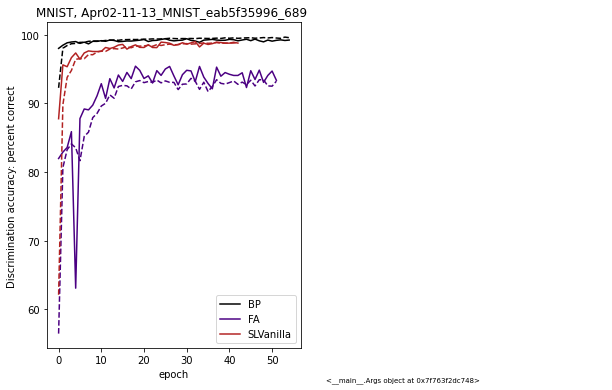

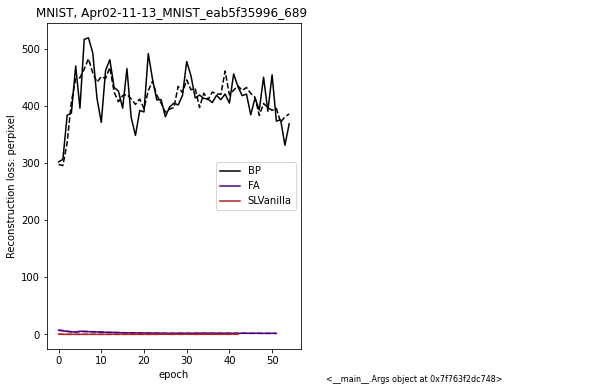

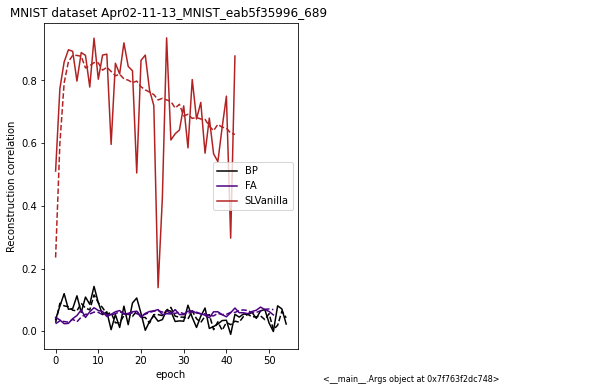

<Figure size 720x432 with 0 Axes>

In [57]:

%matplotlib inline


base_methods = ['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost','SLConv1', 'SLGrConv1', 'SLLatentRobust']
all_methods = copy.deepcopy(base_methods)

print(base_methods)
[all_methods.extend([m+'CC0'] )for m in base_methods]
[all_methods.extend([m+'CC1'] )for m in base_methods]
print(all_methods)
colors = {'BP':'k', 'FA':'indigo', 'SLVanilla':'firebrick','SLError':'navy', 'SLAdvImg':'c','SLAdvCost':'darkolivegreen','SLLatentRobust':'yellow',
               'BPCC0':'dimgrey', 'FACC0':'blueviolet', 'SLVanillaCC0':'r','SLErrorCC0':'blue', 'SLAdvImgCC0':'c','SLAdvCostCC0':'green','SLLatentRobustCC0':'khaki',
               'BPCC1':'lightgrey', 'FACC1':'mediumpurple', 'SLVanillaCC1':'salmon','SLErrorCC1':'lightsteelblue', 'SLAdvImgCC1':'c','SLAdvCostCC1':'lightgreen','SLLatentRobustCC1':'darkgoldenrod',
               'SLConv1':'sandybrown', 'SLGrConv1':'brown' }
# colors =  {'BP':'k', 'FA':'grey', 'SLVanilla':'r','SLRobust':'salmon',
#             'SLError':'orange', 'SLErrorTemplateGenerator':'yellow', 'BSL':'b','SLGAN':'m'}


methods = all_methods #['BP','FA','SLVanilla','SLGAN' ]#',,'SLRobust', 'SLError''SLRobust', 'SLError' ,'BSL',  'SLErrorTemplateGenerator' 'SLError', 

print(methods)

if args.eval_RDMs:
    RDMs_dict = {}
    layers = ['RDM_conv1_FF', 'RDM_conv1_FB', 'RDM_latents_FF', 'RDM_upsample2',]
    import h5py
    for method in  methods:
        hf = h5py.File(args.resultsdir+'RDMs_%s.h5'%method, 'r')
        
        RDM_list = [np.array(hf.get(layers[0])),
        np.array(hf.get(layers[1])),
        np.array(hf.get(layers[2])),
        np.array(hf.get(layers[3]))]
        RDMs_dict.update({method:RDM_list}) 

if len(args.eval_swept_var):
    if args.eval_swept_var=='sigma2':
        non_swept_var='epsilon'
        non_swept_var_value=0.0
        swept_vars = np.arange(0, 1.1, 0.1).tolist() #[0, 0.2, 0.4, 0.6, 0.8, 1]
    
    print(swept_vars)
    sigma2 = 0.0
    maxitr = 4
    Test_acce = {}
    # epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    existing_methods = []
    for method in  methods:
        Test_acce_arr = np.zeros((4, len(swept_vars)))
        for iv , swept_var in enumerate(swept_vars):
            # json_name = '%s_%s_eval%s_maxitr4_epsilon%0.1e.json'%(args.runname, method, args.eval_time, epsilon)
            if args.eval_swept_var=='sigma2':
                json_name = '%s%s_%s_eval%s_maxitr%d_epsilon%0.1e_noisesigma2%.1f.json'%(args.databasedir,args.runname, method, args.eval_time, maxitr, non_swept_var_value, swept_var)
            else:
                json_name = '%s%s_%s_eval%s_maxitr%d_epsilon%0.1e_noisesigma2%.1f.json'%(args.databasedir,args.runname, method, args.eval_time, maxitr, swept_var, sigma2)
            print(json_name)
            try:
                with open(json_name, 'r') as fp:
                                
                    results = json.load(fp)   
                    Test_acce_arr[:, iv] = results['Test_acce']     
                    Test_acce.update({method:Test_acce_arr})
                existing_methods.append(method)
            except FileNotFoundError:
                continue

else:
    Test_acce = {}
    Train_acce = {}
    Test_lossd = {}
    Train_lossd = {}
    Test_lossl = {}
    Train_lossl = {}
    Test_corrd = {}
    Train_corrd = {}
    
    Align_corr_first = {}
    Align_corr_last = {}
    
    Align_ratios_first = {}
    Align_ratios_last = {}
    
    Forward_norm_first = {}
    Forward_norm_last = {}
    
       
    existing_methods = []
    for method in  methods:
        
        try:
            with open('%s%s_%s.json'%(args.databasedir,args.runname, method), 'r') as fp:
                results = json.load(fp)        
                Test_acce.update({method:results['Test_acce']})
                Train_acce.update({method:results['Train_acce']})

                Test_lossd.update({method:results['Test_lossd']})
                Train_lossd.update({method:results['Train_lossd']})


                Test_lossl.update({method:results['Test_lossl']})
                Train_lossl.update({method:results['Train_lossl']})

                Test_corrd.update({method:results['Test_corrd']})
                Train_corrd.update({method:results['Train_corrd']})
                
                Align_corr_first.update({method:results['Alignments_corrs_first_layer']})
                Align_corr_last.update({method:results['Alignments_corrs_last_layer']})
                
                Align_ratios_first.update({method:results['Alignments_ratios_first_layer']})
                Align_ratios_last.update({method:results['Alignments_ratios_last_layer']})
                
                Forward_norm_first.update({method:results['Forward_norm_first_layer']})
                Forward_norm_last.update({method:results['Forward_norm_last_layer']})
                              
            existing_methods.append(method)
        except FileNotFoundError:
            print('%s%s_%s.json was not found'%(args.databasedir,args.runname, method))
            continue
                        

existing_methods = np.unique(existing_methods)


# args.resultsdir = args.resultsdir.replace('ConvMNIST_playground', 'SYY2020')
resultsdir = path_prefix + args.resultsdir.split('/Research')[1]
pp.pprint(vars(args))
# I used to save results into numpy files

# list_npy = find( '*.npy', resultsdir )
# print(list_npy)
# print(os.listdir(resultsdir))

# results = {}
# for f in list_npy:
#     print(f[:-4])
#     k = f[:-4].split('_')[0] + '_%s'%f[:-4].split('_')[1]
#     r = np.load(resultsdir + f)
#     results.update({k:r})
# print(results.keys())

if args.eval_RDMs:
    # bar plots
    corrs = [ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0] for l in range(4)]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[5.5,4])
    
    width = 0.35
    dist = width/4

    l=0
    axes.bar([0],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='1st layer-forward', color='salmon')
    l=1
    axes.bar([width+dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='1st layer-feedback',color='r')
    l=2
    axes.bar([0.5+3/2*width+2*dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='top layer-forward',color='lightblue')
    l=3
    axes.bar([0.5+5/2*width+3*dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='top layer-feedback',color='b')
    
    mixed_1st_layer_SLVanilla = np.concatenate((RDMs_dict['SLVanilla'][0].ravel(),RDMs_dict['SLVanilla'][1].ravel()))
    mixed_top_layer_SLVanilla = np.concatenate((RDMs_dict['SLVanilla'][2].ravel(),RDMs_dict['SLVanilla'][3].ravel()))

    mixed_1st_layer_BP = np.concatenate((RDMs_dict['BP'][0].ravel(),RDMs_dict['BP'][1].ravel()))
    mixed_top_layer_BP = np.concatenate((RDMs_dict['BP'][2].ravel(),RDMs_dict['BP'][3].ravel()))


    print('SHAPE',mixed_1st_layer_BP.shape)
    axes.bar([1+7/2*width+4*dist],1-ss.pearsonr(mixed_1st_layer_BP, mixed_1st_layer_SLVanilla)[0],width=width, label='1st layer-mixed',color='firebrick')
    axes.bar([1+9/2*width+5*dist],1-ss.pearsonr(mixed_top_layer_BP, mixed_top_layer_SLVanilla)[0],width=width, label='top layer-mixed',color='darkblue')
    
    
    
    axes.legend(loc='upper right')
    axes.set_ylabel('Dissimilarity between RSMs of SL and BP')
    axes.set_xticks([])
    ax = plt.gca()
    ax.patch.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='y',direction='out', right=False)
    plt.tick_params(axis='x',direction='out', top=False)
    fig.savefig(args.resultsdir+'Bars_RDMs_comparisons_%s.png'%(args.runname), dpi=200)
    fig.savefig(args.resultsdir+'Bars_RDMs_comparisons_%s.pdf'%(args.runname), dpi=200)
    plt.clf()

    #

    # RDM consistencies
    RDMs_consistencies = np.zeros((len(methods), len(methods), 4))
    for i, methodi in enumerate(methods):
        for j, methodj in enumerate(methods):
            for l in range(4):
                RDMs_consistencies[i, j , l] = ss.pearsonr(RDMs_dict[methodi][l].ravel(), RDMs_dict[methodj][l].ravel())[0]
                print(methodi,methodj,RDMs_consistencies[:,:,l ])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[12,4])
    for l in range(4):
        im = axes[l].matshow(RDMs_consistencies[:, : , l], vmin=0, vmax=1, origin='lower', cmap=plt.cm.get_cmap('Spectral_r'))
        axes[l].set_xticks(range(len(methods)))
        axes[l].set_xticklabels(methods)
        if l ==0:
            axes[l].set_yticks(range(len(methods)))
            axes[l].set_yticklabels(methods)
        else:
            axes[l].set_yticks([])

        
        axes[l].set_title(layers[l][4:], y=1.25)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Correlation between RDMs %s, %s'%(args.runname, args.dataset))
    plt.show()
#     fig.savefig(args.resultsdir+'RDMs_comparisons_%s.png'%(args.runname), dpi=200)
#     fig.savefig(args.resultsdir+'RDMs_comparisons_%s.pdf'%(args.runname), dpi=200)
#     plt.clf()

elif len(args.eval_swept_var):
    print(existing_methods)
    #------ accuracy ------------
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[20,4])

    for itr in range(4):
        for method in existing_methods:
            if itr == 3 :
                axes[itr].plot(swept_vars, Test_acce[method][itr], color=colors[method], label=method)
            else:
                axes[itr].plot(swept_vars, Test_acce[method][itr], color=colors[method])

        axes[itr].set_xlabel(args.eval_swept_var)
        axes[itr].set_ylabel('Discrimination accuracy: percent correct')
        axes[itr].set_title('itr = %d'%itr)
        axes[itr].set_ylim([0,100])
        

        fig.suptitle('%s dataset %s eval%s %s=%s'%(args.dataset, args.runname, args.eval_time, non_swept_var ,non_swept_var_value))

        # axes[1].set_xticks([])
        # axes[1].set_yticks([])
        # axes[1].axis('off')
        # txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
        # txt._get_wrap_line_width = lambda : 200

    axes[3].legend()

#     fig.savefig(resultsdir+'robust_results_eval%s_%s_%s.pdf'%(args.eval_time, non_swept_var,non_swept_var_value), dpi=200)
#     fig.savefig(resultsdir+'robust_results_eval%s_%s_%s.png'%(args.eval_time, non_swept_var,non_swept_var_value), dpi=200)

    plt.clf()


else:

    #------ accuracy ------------
    summary_dic_Train = {}
    summary_dic_Test = {}
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:
         
            axes[0].plot(Train_acce[method], color=colors[method], ls='--')
            axes[0].plot(Test_acce[method], color=colors[method], label=method)
        
            print('Train ACC','%s:'%method, Train_acce[method][-1], end =" ")
            print('**')
            print('Test ACC','%s:'%method, Test_acce[method][-1], end =" ")
            print('**')
            summary_dic_Train.update({method: [Train_acce[method][-1], Train_lossd[method][-1], Train_lossl[method][-1],Train_corrd[method][-1], len(Train_acce[method])]})
            summary_dic_Test.update({method: [Test_acce[method][-1], Test_lossd[method][-1], Test_lossl[method][-1],Test_corrd[method][-1], len(Test_acce[method])]})

    df_train = pd.DataFrame.from_dict(summary_dic_Train, orient='index', columns=['Accuracy', 'LossPixel','LossLatent','CorrPixel','Epoch'])
    df_train = df_train.sort_values('Accuracy', ascending=False)

    df_test = pd.DataFrame.from_dict(summary_dic_Test, orient='index', columns=['Accuracy', 'LossPixel','LossLatent','CorrPixel','Epoch'])
    df_test = df_test.sort_values('Accuracy', ascending=False)
    print('*Train*')
    print(df_train)
    print('*Test*')
    print(df_test)
    df_train.to_csv(args.resultsdir+'df_train_%s.csv'%args.runname, sep=',')
    df_test.to_csv(args.resultsdir+'df_test_%s.csv'%args.runname, sep=',')
    # # axes[0].plot(results['SLBP_Train'][:,1],  color='lightgrey', label='SLBP %.2f'%results['SLBP_Test'][0,1])
    # axes[0].plot(results['SLDecoderRobustOutput_Train'][:,1],  color='lightgrey', label='SLDecoderRobustOutput %.2f'%results['SLDecoderRobustOutput_Test'][0,1])

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Discrimination accuracy: percent correct')
    axes[0].set_title('%s, %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=7 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'acc_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'acc_results_%depochs.png'%args.epochs, dpi=200)
#     plt.show()
#     plt.clf()

    #------ reconstruction loss ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])
    
    for method in existing_methods:
        
        axes[0].plot(Train_lossd[method], color=colors[method], ls='--')

        axes[0].plot(Test_lossd[method], color=colors[method], label=method)
  

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Reconstruction loss: perpixel')
    axes[0].set_title('%s, %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'lossd_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'lossd_results_%depochs.png'%args.epochs, dpi=200)

#     plt.clf()



    #------ reconstruction corr ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:


        axes[0].plot(Train_corrd[method], color=colors[method], ls='--')

        axes[0].plot(Test_corrd[method], color=colors[method], label=method)

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Reconstruction correlation')
    axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


# #     fig.savefig(resultsdir+'corrd_results_%depochs.pdf'%args.epochs, dpi=200)
# #     fig.savefig(resultsdir+'corrd_results_%depochs.png'%args.epochs, dpi=200)

#     plt.clf()
#     plt.show()

    #------ alignment corr ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:


        axes[0].plot(Align_corr_first[method], color=colors[method], ls='--',label=method)

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Alignment correlation')
    axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'corrd_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'corrd_results_%depochs.png'%args.epochs, dpi=200)

    plt.clf()
    plt.show()
    
    


In [58]:
 existing_methods

array(['BP', 'FA', 'SLVanilla'], dtype='<U9')

Text(0.5, 0.98, 'MNIST dataset Apr02-11-13_MNIST_eab5f35996_689 ')

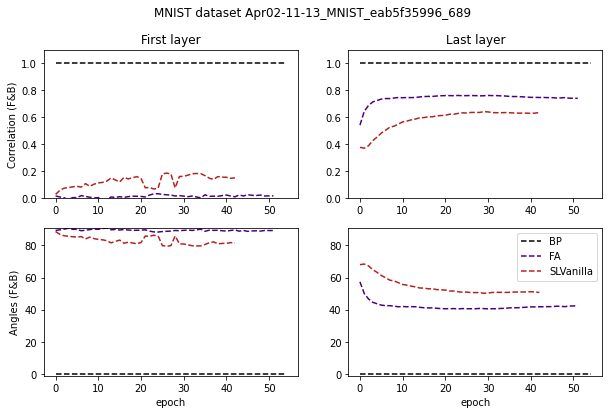

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10,6])

for method in existing_methods:


    axes[0,0].plot(Align_corr_first[method], color=colors[method], ls='--',label=method)
    axes[0,1].plot(Align_corr_last[method], color=colors[method], ls='--',label=method)
    
    axes[1,0].plot(180*np.arccos(np.array(Align_corr_first[method]))/np.pi, color=colors[method], ls='--',label=method)
    axes[1,1].plot(180*np.arccos(np.array(Align_corr_last[method]))/np.pi, color=colors[method], ls='--',label=method)
    


axes[0,0].set_ylabel('Correlation (F&B)')
axes[1,0].set_ylabel('Angles (F&B)')

axes[0,0].set_ylim([0,1.1])
axes[0,1].set_ylim([0,1.1])
axes[1,0].set_ylim([-1,91])
axes[1,1].set_ylim([-1,91])

axes[1,1].legend()

axes[1,0].set_xlabel('epoch')
axes[1,1].set_xlabel('epoch')

axes[0,0].set_title('First layer')
axes[0,1].set_title('Last layer')

# axes[1,0].set_xticks([])
# axes[1,0].set_yticks([])
# axes[1,0].axis('off')
# txt= axes[1,0].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
# txt._get_wrap_line_width = lambda : 200
fig.suptitle('%s dataset %s '%(args.dataset, args.runname))

#     fig.savefig(resultsdir+'corrd_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'corrd_results_%depochs.png'%args.epochs, dpi=200)



KeyError: 'BP'

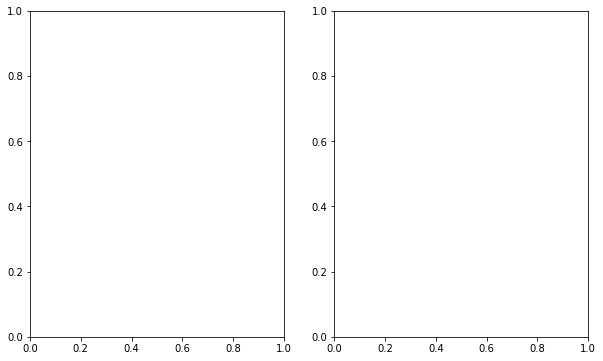

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

for method in existing_methods:

    angle = np.arccos(Align_angles_first[method])
    axes[0].plot(angle*180/np.pi, color=colors[method], ls='--',label=method)

axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Alignment angle: First layer')
axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
axes[0].legend()

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axis('off')
txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
txt._get_wrap_line_width = lambda : 200

/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


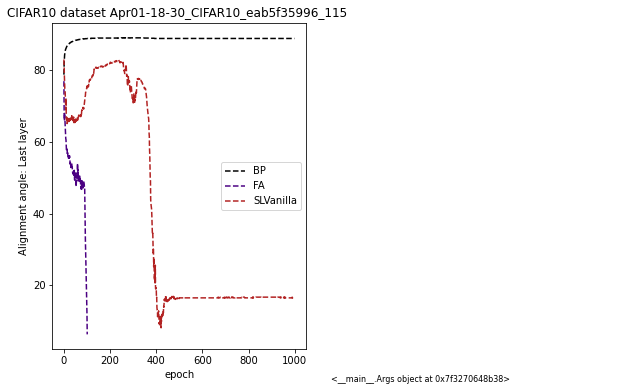

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

for method in existing_methods:
   
    angle = np.arccos(Align_angles_last[method])
    axes[0].plot(angle*180/np.pi, color=colors[method], ls='--',label=method)

axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Alignment angle: Last layer')
axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
axes[0].legend()

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axis('off')
txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
txt._get_wrap_line_width = lambda : 200

/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


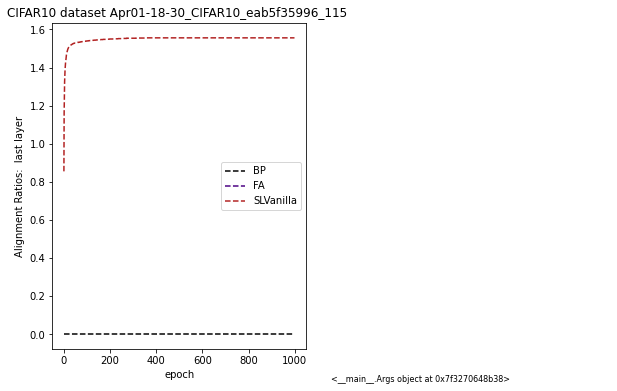

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10,6])

for method in existing_methods:
   
    metric = np.arccos(Align_ratios_last[method])
    axes[0].plot(metric, color=colors[method], ls='--',label=method)

axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Alignment Ratios:  last layer')
axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
axes[0].legend()

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axis('off')
txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
txt._get_wrap_line_width = lambda : 200

/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


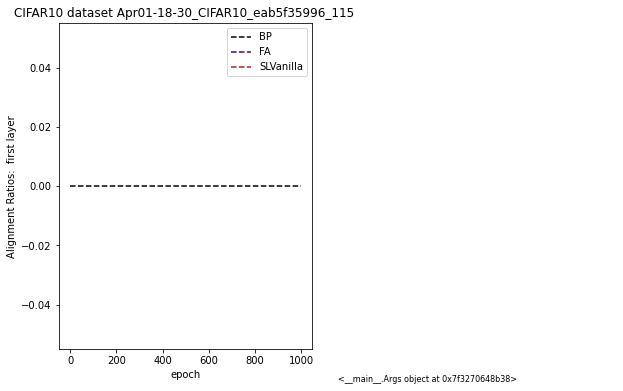

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

for method in existing_methods:
   
    metric = np.arccos(Align_ratios_first[method])
    axes[0].plot(metric, color=colors[method], ls='--',label=method)

axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Alignment Ratios:  first layer')
axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
axes[0].legend()

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].axis('off')
txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
txt._get_wrap_line_width = lambda : 200

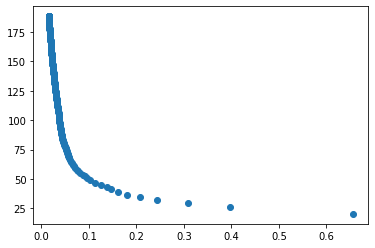

In [48]:
method='SLVanilla'
plt.scatter(np.array(Align_ratios_last[method]), np.array(Forward_norm_last[method]))

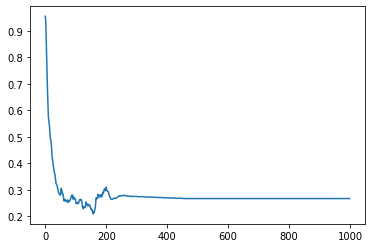

In [38]:
plt.plot(np.array(Align_ratios_last[method]))

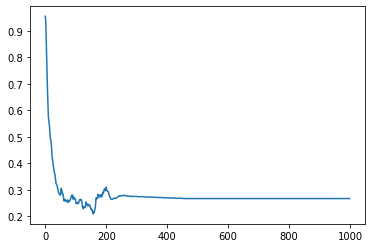

In [40]:
plt.plot(np.array(Forward_norm_last[method]))